<a href="https://colab.research.google.com/github/jungmin0710/K-digital-PythonDeepLearning/blob/main/Image_Segmentation_GPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Segmentation
* REDNet Fine Tuning 
  * https://dambaekday.tistory.com/3 
  * https://m.blog.naver.com/laonple/220985349467

In [1]:
import warnings 

warnings.filterwarnings('ignore')

## 0.Import Package

In [2]:
import tensorflow as tf 
import numpy as np

## 1.Oxford_IIIT Pet Data_Set

### 1) 학습용 'Image'와 'Label' 다운로드 
* 'Image'의 경계선과 내용, 외곽 3가지 분류 학습

In [3]:
# x를 픽셀단위로 구분해놓은 y가 필요하다 x를 픽셀단위로 구분해놓은 y가 필요하다
import tensorflow_datasets as tfds 

dataset, info = tfds.load('oxford_iiit_pet:3.2.0', with_info=True)
import tensorflow_datasets as tfds 

dataset, info = tfds.load('oxford_iiit_pet:3.2.0', with_info=True)

Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteTHDXHY/oxford_iiit_pet-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteTHDXHY/oxford_iiit_pet-test.tfrecord


Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


* tfds 에러 시 사용

In [4]:
# !python -m tensorflow_datasets.scripts.download_and_prepare --register_checksums --datasets = oxf

### 2) Data_Set Information 
* features
  * image - shape=(None, None, 3) 
  * label - num_claasses=37
  * segmentation_mask - shape=(None, None, 1)
* split
  * train : 3680
  * test : 3669


In [5]:
info

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    version=3.2.0,
    description='The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
images for each class. The images have large variations in scale, pose and
lighting. All images have an associated ground truth annotation of breed.',
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=tf.uint8),
        'species': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    total_num_examples=7349,
    splits={
        'test': 3669,
        'train': 3680,
    },
    supervised_keys=('image', 'label'),
    citation="""@InProceedings{parkhi12a,
      author       = "Parkhi, O. M. and Vedaldi, A. and Zisserman, A. and Ja

### 3) 'train', 'test' 데이터 수 저장

In [6]:
train_data_len = info.splits['train'].num_examples 
test_data_len = info.splits['test'].num_examples

## 2.load_image( )

### 1) 함수 정의
* 'image' and 'segmetation_mask' 
* Resize : (128, 128) 
* Normalization

In [7]:
def load_image(datapoint):
  img = tf.image.resize(datapoint['image'], (128, 128)) 
  mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  img = tf.cast(img, tf.float32) 
  img = img / 255.0 
  mask = mask - 1
  
  return img, mask

### 2) 'train_dataset' and 'test_dataset' 정의

In [8]:
train_dataset = dataset['train'].map(load_image) 
train_dataset = train_dataset.repeat() 
train_dataset = train_dataset.batch(16)

test_dataset = dataset['test'].map(load_image) 
test_dataset = test_dataset.repeat() 
test_dataset = test_dataset.batch(1)

## 3.'image' and 'segmentation_mask' 확인
* 각 픽셀의 값을 중심부, 배경, 외곽선으로 분류 하는 문제 
  * 중심부 : '1' 
  * 배경 : '2' 
  * 외곽선 : '3'
* mask의 'label'이 '0'부터 시작하도록 설정

0.3996089 0.00047392002


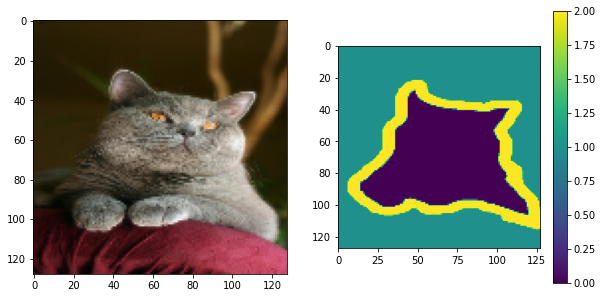

In [10]:
import matplotlib.pyplot as plt

for img, mask in train_dataset.take(1): 
  plt.figure(figsize = (10, 5))
  
  plt.subplot(1, 2, 1) 
  plt.imshow(img[2])
  
  plt.subplot(1, 2, 2) 
  plt.imshow(np.squeeze(mask[2], axis = 2)) 
  plt.colorbar()
  
  print(np.amax(img[1][2]), np.amin(img[1][2]))

## 4.REDNet Fine Tuning

### 1) 마지막 레이어 수정 
* deconv_layers : 'softmax' Activation

In [16]:
def REDNet_segmentation(num_layers): 
  conv_layers = [] 
  deconv_layers = [] 
  residual_layers = []

  inputs = tf.keras.layers.Input(shape = (None, None, 3)) 
  conv_layers.append(tf.keras.layers.Conv2D(3,
                                            kernel_size = 3, 
                                            padding = 'same', 
                                            activation = 'relu'))
  
  for i in range(num_layers - 1): 
    conv_layers.append(tf.keras.layers.Conv2D(64,
                                              kernel_size = 3, 
                                              padding = 'same', 
                                              activation = 'relu'))
    deconv_layers.append(tf.keras.layers.Conv2DTranspose(64,
                                                       kernel_size = 3, 
                                                       padding = 'same', 
                                                       activation = 'relu'))

  deconv_layers.append(tf.keras.layers.Conv2DTranspose(3,
                                                       kernel_size = 3, 
                                                       padding = 'same', 
                                                       activation = 'softmax'))
  x = conv_layers[0](inputs)

  for i in range(num_layers - 1): 
    x = conv_layers[i + 1](x) 
    if i % 2 == 0:
      residual_layers.append(x)
  
  for i in range(num_layers - 1): 
    if i % 2 == 1:
      x = tf.keras.layers.Add()([x, residual_layers.pop()]) 
      x = tf.keras.layers.Activation('relu')(x) 
    x = deconv_layers[i](x)

  x = deconv_layers[-1](x)
  
  model = tf.keras.Model(inputs = inputs, outputs = x) 
  return model

### 2) Model Compile

In [17]:
model = REDNet_segmentation(15) 

model.compile(loss = 'sparse_categorical_crossentropy',
              optimizer = tf.optimizers.Adam(0.0001), 
              metrics = ['accuracy'])

### 3) Model Fit

In [18]:
%%time

history = model.fit(train_dataset, 
                    epochs = 20,
                    steps_per_epoch = train_data_len // 16, 
                    validation_data = test_dataset, 
                    validation_steps = test_data_len)

Epoch 1/20
230/230 [==============================] - 169s 584ms/step - loss: 0.9483 - accuracy: 0.5706 - val_loss: 0.8340 - val_accuracy: 0.5731
Epoch 2/20
230/230 [==============================] - 134s 582ms/step - loss: 0.7976 - accuracy: 0.6128 - val_loss: 0.8126 - val_accuracy: 0.6265
Epoch 3/20
230/230 [==============================] - 134s 584ms/step - loss: 0.7461 - accuracy: 0.6653 - val_loss: 0.7730 - val_accuracy: 0.6606
Epoch 4/20
230/230 [==============================] - 135s 586ms/step - loss: 0.6926 - accuracy: 0.6975 - val_loss: 0.6691 - val_accuracy: 0.7128
Epoch 5/20
230/230 [==============================] - 135s 586ms/step - loss: 0.6412 - accuracy: 0.7235 - val_loss: 0.6341 - val_accuracy: 0.7301
Epoch 6/20
230/230 [==============================] - 134s 585ms/step - loss: 0.6106 - accuracy: 0.7379 - val_loss: 0.5907 - val_accuracy: 0.7504
Epoch 7/20
230/230 [==============================] - 134s 584ms/step - loss: 0.5855 - accuracy: 0.7504 - val_loss: 0.5717 -

## 5.Model Validation

### 1) 테스트 이미지 분할 확인 
* 'image', 'segmentation_mask', 'learned_mask'

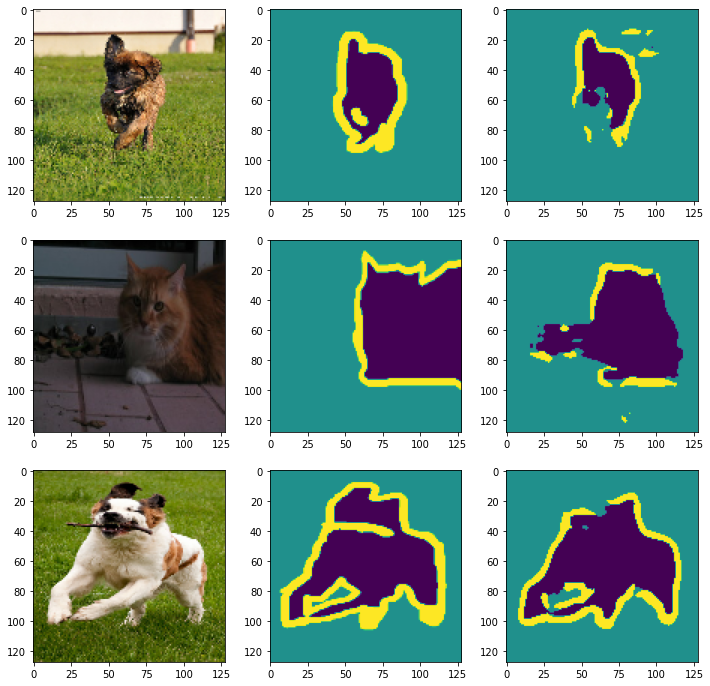

In [19]:
plt.figure(figsize = (12, 12)) 

for idx, (img, mask) in enumerate(test_dataset.take(3)): 
  plt.subplot(3, 3, idx*3 + 1) 
  plt.imshow(img[0])
  
  plt.subplot(3, 3, idx*3 + 2) 
  plt.imshow(np.squeeze(mask[0], axis = 2))
  
  predict = tf.argmax(model.predict(img), axis = -1) 
  plt.subplot(3, 3, idx*3 + 3) 
  plt.imshow(np.squeeze(predict, axis = 0))

### 2) 테스트 이미지 분할 확인(원본)

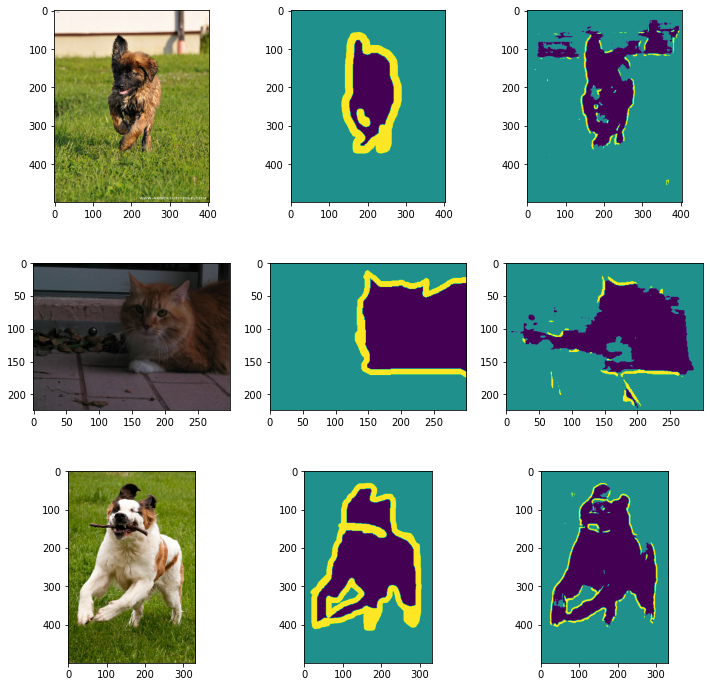

In [20]:
plt.figure(figsize = (12, 12))

for idx, datapoint in enumerate(dataset['test'].take(3)): 
  img = datapoint['image'] 
  mask = datapoint['segmentation_mask']

  img = tf.cast(img, tf.float32) 
  img = img / 255.0 
  mask = mask - 1

  plt.subplot(3, 3, idx*3 + 1) 
  plt.imshow(img)

  plt.subplot(3, 3, idx*3 + 2) 
  plt.imshow(np.squeeze(mask, axis = 2))

  predict = tf.argmax(model.predict(tf.expand_dims(img, axis = 0)), axis = -1) 
  plt.subplot(3, 3, idx*3 + 3) 
  plt.imshow(np.squeeze(predict, axis = 0))

본 내용은 2021/03/25(목)에 학습한 내용입니다.